In [1]:
%matplotlib inline


In [2]:
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")

import matplotlib.pyplot as plt
plt.close("all")


In [29]:
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter, defaultdict
from PIL import Image
import imagehash


In [30]:
ROOT = r"E:\projects\TrainingFPDModel\End-to-End-DL-Pipeline2\datasets\FURNITURE_DETECTION.v1"
IMAGES_DIR = os.path.join(ROOT, "train/images")
LABELS_DIR = os.path.join(ROOT, "train/labels")
DATA_YAML = os.path.join(ROOT, "data.yaml")


In [5]:
with open(DATA_YAML, "r") as f:
    cfg = yaml.safe_load(f)

names = cfg["names"]
nc = len(names)

print(f"Classes ({nc}):")
for i, n in enumerate(names):
    print(i, "→", n)


Classes (25):
0 → TV
1 → TV_console
2 → armchair
3 → bathroom
4 → bedside_table
5 → carpet
6 → chair
7 → coffee_table
8 → desk
9 → dining_table
10 → double_bed
11 → freezer
12 → indoor_plants
13 → kitchen_set
14 → office_chair
15 → other_furniture
16 → shower_cabin
17 → single_bed
18 → sink
19 → sofa
20 → staircase
21 → stool
22 → stove
23 → toilets
24 → wardrobe


In [31]:

class_counts = Counter()
objects_per_image = []
box_areas = []
invalid_labels = 0
tiny_boxes = 0
extreme_aspect = 0
out_of_bounds = 0

box_areas_per_class = defaultdict(list)
images_per_class = defaultdict(set)

empty_images = 0


image_hashes = defaultdict(list)


In [32]:
image_files = [f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(".jpg") or f.lower().endswith(".png")]

for img_name in tqdm(image_files):
    img_path = os.path.join(IMAGES_DIR, img_name)
    lbl_path = os.path.join(LABELS_DIR, img_name.rsplit(".", 1)[0] + ".txt")
    # ---------- Duplicate detection ----------
    img = Image.open(img_path).convert("RGB")
    ph = imagehash.phash(img)
    image_hashes[str(ph)].append(img_path)

    # ---------- Labels ----------
    if not os.path.exists(lbl_path):
        objects_per_image.append(0)
        empty_images += 1
        continue

    with open(lbl_path, "r") as f:
        lines = [l.strip() for l in f if l.strip()]

    objects_per_image.append(len(lines))

    for line in lines:
        try:
            # cls, xc, yc, w, h = map(float, line.split())
            # cls = int(cls)

            # if cls < 0 or cls >= nc or w <= 0 or h <= 0:
            #     invalid_labels += 1
            #     continue

            # class_counts[cls] += 1
            # box_areas.append(w * h)
            cls, xc, yc, w, h = map(float, line.split())
            cls = int(cls)

            if cls < 0 or cls >= nc:
                invalid_labels += 1
                continue

            if not (0 <= xc <= 1 and 0 <= yc <= 1 and 0 < w <= 1 and 0 < h <= 1):
                invalid_labels += 1
                out_of_bounds += 1
                continue

            if xc - w/2 < 0 or xc + w/2 > 1 or yc - h/2 < 0 or yc + h/2 > 1:
                invalid_labels += 1
                out_of_bounds += 1
                continue

            area = w * h
            if area < 0.0005:
                tiny_boxes += 1

            ar = w / h
            if ar < 0.05 or ar > 20:
                extreme_aspect += 1

            class_counts[cls] += 1
            box_areas.append(area)
            box_areas_per_class[cls].append(area)
            images_per_class[cls].add(img_name)


        except:
            invalid_labels += 1


  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 53.56it/s]


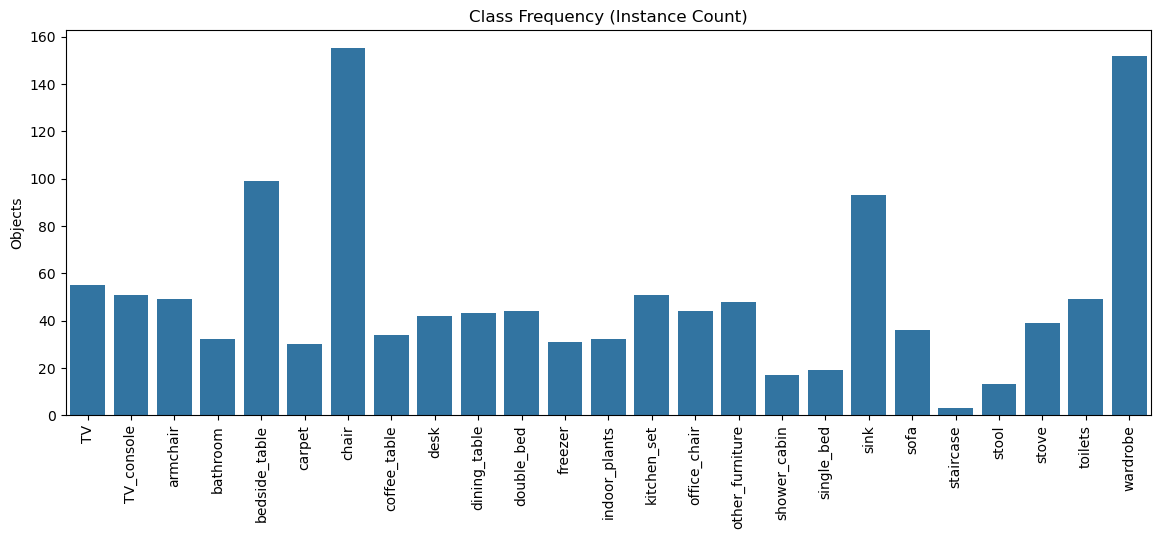

In [33]:
plt.figure(figsize=(14,5))
cls_ids = sorted(class_counts.keys())
counts = [class_counts[c] for c in cls_ids]

sns.barplot(x=[names[c] for c in cls_ids], y=counts)
plt.xticks(rotation=90)
plt.title("Class Frequency (Instance Count)")
plt.ylabel("Objects")
plt.show()


In [34]:
counts_arr = np.array(counts)
max_c, min_c = counts_arr.max(), counts_arr.min()

print(f"Max / Min class ratio = {max_c / min_c:.2f}")

if max_c / min_c > 10:
    print("❌ Severe class imbalance")
elif max_c / min_c > 3:
    print("⚠ Mild imbalance")
else:
    print("✓ Acceptable balance")


Max / Min class ratio = 51.67
❌ Severe class imbalance


In [35]:
print("Tiny boxes:", tiny_boxes)
print("Extreme aspect ratio boxes:", extreme_aspect)
print("Out-of-bounds boxes:", out_of_bounds)

print("\nImages per class:")
for cls, imgs in images_per_class.items():
    print(f"Class {cls}: {len(imgs)} images")


Tiny boxes: 1
Extreme aspect ratio boxes: 0
Out-of-bounds boxes: 0

Images per class:
Class 9: 40 images
Class 6: 37 images
Class 2: 27 images
Class 1: 37 images
Class 0: 33 images
Class 10: 39 images
Class 24: 42 images
Class 14: 30 images
Class 4: 36 images
Class 12: 12 images
Class 7: 29 images
Class 8: 31 images
Class 13: 26 images
Class 22: 39 images
Class 18: 42 images
Class 11: 31 images
Class 19: 28 images
Class 23: 41 images
Class 3: 32 images
Class 15: 20 images
Class 17: 13 images
Class 5: 14 images
Class 16: 16 images
Class 21: 4 images
Class 20: 3 images


In [36]:
print("Number of classes with annotations:", len(class_counts))
print("Raw class_counts:")
for k, v in class_counts.items():
    print(k, names[k], v)


Number of classes with annotations: 25
Raw class_counts:
9 dining_table 43
6 chair 155
2 armchair 49
1 TV_console 51
0 TV 55
10 double_bed 44
24 wardrobe 152
14 office_chair 44
4 bedside_table 99
12 indoor_plants 32
7 coffee_table 34
8 desk 42
13 kitchen_set 51
22 stove 39
18 sink 93
11 freezer 31
19 sofa 36
23 toilets 49
3 bathroom 32
15 other_furniture 48
17 single_bed 19
5 carpet 30
16 shower_cabin 17
21 stool 13
20 staircase 3


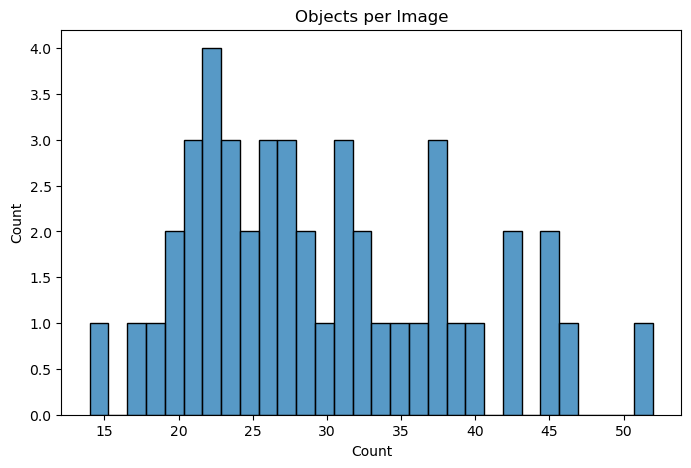

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(objects_per_image, bins=30)
plt.title("Objects per Image")
plt.xlabel("Count")
plt.show()


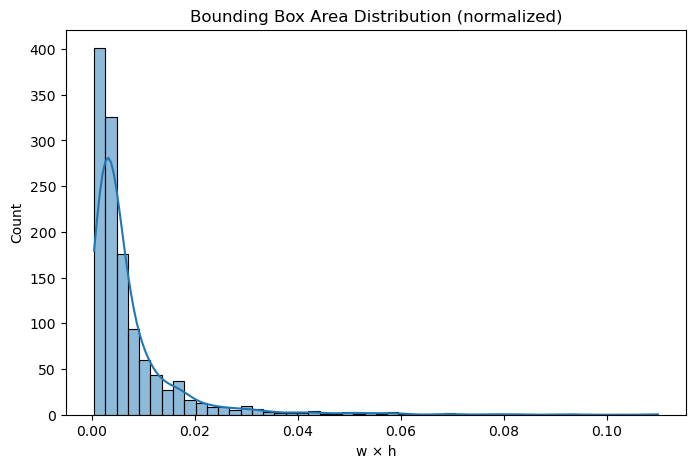

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(box_areas, bins=50, kde=True)
plt.title("Bounding Box Area Distribution (normalized)")
plt.xlabel("w × h")
plt.show()


In [38]:
print("Total images:", len(image_files))
print("Images with no annotations:", empty_images)
print("Invalid label entries:", invalid_labels)
print("Avg objects per image:", np.mean(objects_per_image))


Total images: 45
Images with no annotations: 0
Invalid label entries: 71
Avg objects per image: 29.6


In [17]:
duplicates = {h: paths for h, paths in image_hashes.items() if len(paths) > 1}

print(f"Duplicate groups found: {len(duplicates)}")

for h, paths in list(duplicates.items())[:5]:
    print("\nDuplicate group:")
    for p in paths:
        print(p)


Duplicate groups found: 0


In [18]:
print("\n--- DATASET HEALTH SUMMARY ---")

if max_c / min_c > 10:
    print("• Severe class imbalance")
if empty_images > 0:
    print("• Empty images present")
if invalid_labels > 0:
    print("• Invalid annotations detected")
if len(duplicates) > 0:
    print("• Duplicate images detected")
if np.mean(objects_per_image) < 3:
    print("• Very sparse annotations")

print("Review above issues before training.")



--- DATASET HEALTH SUMMARY ---
• Severe class imbalance
• Invalid annotations detected
Review above issues before training.


In [19]:
print("Total images scanned:", len(image_files))
print("Total objects:", sum(class_counts.values()))
print("Classes (defined in yaml):", nc)
print("Classes with annotations:", len(class_counts))
print("Avg objects per image:", np.mean(objects_per_image))
print("Images with zero objects:", objects_per_image.count(0))


Total images scanned: 45
Total objects: 1261
Classes (defined in yaml): 25
Classes with annotations: 25
Avg objects per image: 29.6
Images with zero objects: 0


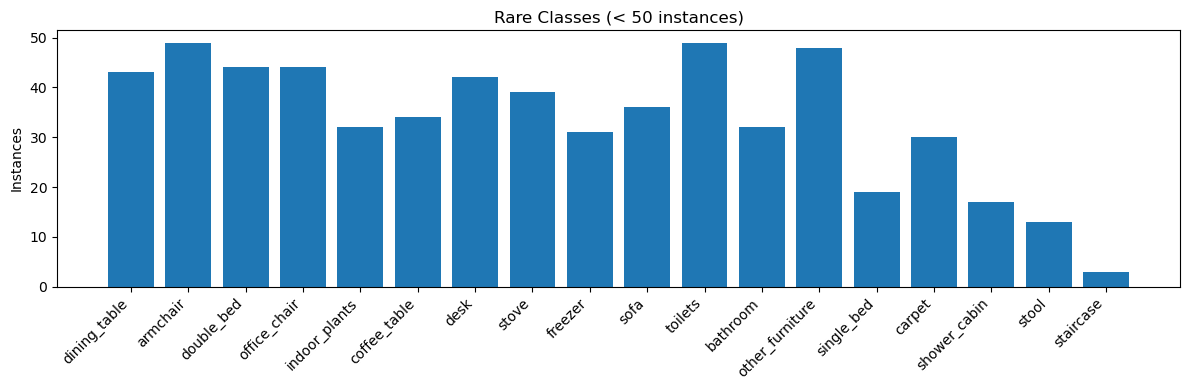

In [23]:
rare_threshold = 50
rare_classes = [(c, v) for c, v in class_counts.items() if v < rare_threshold]

plt.figure(figsize=(12,4))
plt.bar(
    [names[c] for c, _ in rare_classes],
    [v for _, v in rare_classes]
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Instances")
plt.title(f"Rare Classes (< {rare_threshold} instances)")
plt.tight_layout()
plt.show()


In [27]:
invalid_examples = []

for line in lines:
    try:
        cls, xc, yc, w, h = map(float, line.split())
        cls = int(cls)

        if cls < 0 or cls >= nc or w <= 0 or h <= 0:
            invalid_labels += 1
            invalid_examples.append(line.strip())
            continue

        class_counts[cls] += 1
        box_areas.append(w * h)

    except Exception as e:
        invalid_labels += 1
        invalid_examples.append(line.strip())


In [28]:
print(invalid_examples[:70])


['13 0.8640625 0.5228658536585366 0.8640625 0.5990853658536586 0.965625 0.5945121951219512 0.96875 0.2942073170731707 0.8828125 0.2972560975609756 0.884375 0.5259146341463414 0.8640625 0.5228658536585366']
